# num2date 
num2date(...) returns datetime objects given numeric time values. The function uses [CF Conventions and Metadata](http://cfconventions.org/)

In the following example we read in [atmospheric reanalysis data](http://icdc.zmaw.de/1/daten/reanalysis-atmosphere.html) in NetCDF format and plot the time series at some selected positions. We use the num2date module to efficiently decode the datetime from the meta-information. We demonstrate the use of Pandas functions for calculating the rolling mean and for selecting periods. Finally, we calculate seasonal cycles, anomalies and a linear regression of the anomalies. 

Example derived from http://earthpy.org/pandas_netcdf.html

In [161]:
%pylab inline
import pandas as pd
from netCDF4 import Dataset, num2date
from mpl_toolkits.basemap import Basemap
import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [55]:
fn='/data/icdc/reanalyses/ncep_reanalysis1/DATA/2m_airtemp_monthly/air2m.mon.mean.nc'
fn='/home/lars/data/air2m.mon.mean.nc' # local copy
f = Dataset(fn)
print(f.description)
print(f.References)
air = f.variables['air'][:]-273.15
time = f.variables['time']
lon = f.variables['lon'][:]
lat = f.variables['lat'][:]
date=num2date(time[:], time.units)

Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html


In [57]:
date[:3] # show first three entries

array([datetime.datetime(1948, 1, 1, 0, 0),
       datetime.datetime(1948, 2, 1, 0, 0),
       datetime.datetime(1948, 3, 1, 0, 0)], dtype=object)

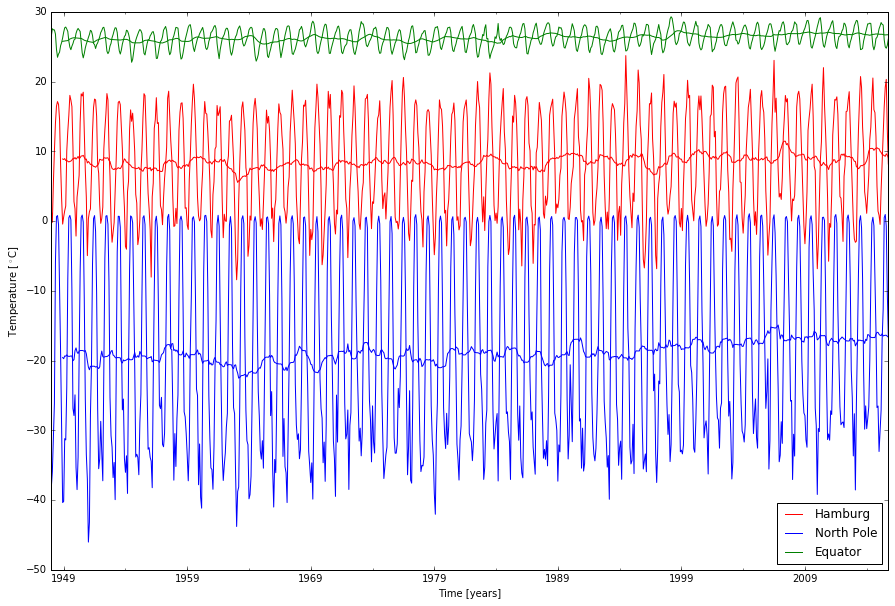

In [93]:
D={'Hamburg':(10.0,53.3),'Equator':(0.0,0.0),'North Pole':(0,90.0)} # Define locations
col={'Hamburg':'r','Equator':'g','North Pole':'b'} # Define colors
D_timeseries={} # Empty dictionary

figure(figsize=(15,10))

for k in D.keys():
    lon0,lat0=D[k]
    ilon,ilat=argmin(abs(lon-lon0)),argmin(abs(lat-lat0)) # Select index for location
    # Generate Pandas Time Series Object and store in dictionary
    D_timeseries[k]=pd.Series(air[:,ilat,ilon],index=date)
    y1=D_timeseries[k]
    y1.plot(color=col[k],label=k)
    pd.rolling_mean(y1,12).plot(color=col[k],label='') # Calculate rolling mean
    legend(loc=4)
xlabel('Time [years]')
ylabel('Temperature [$^\circ$C]')

## Calculate seasonal cycles

In [91]:
periods = dates_pd.to_period(freq='M')
periods

PeriodIndex(['1948-01', '1948-02', '1948-03', '1948-04', '1948-05', '1948-06',
             '1948-07', '1948-08', '1948-09', '1948-10',
             ...
             '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
             '2015-07', '2015-08', '2015-09', '2015-10'],
            dtype='int64', length=814, freq='M')

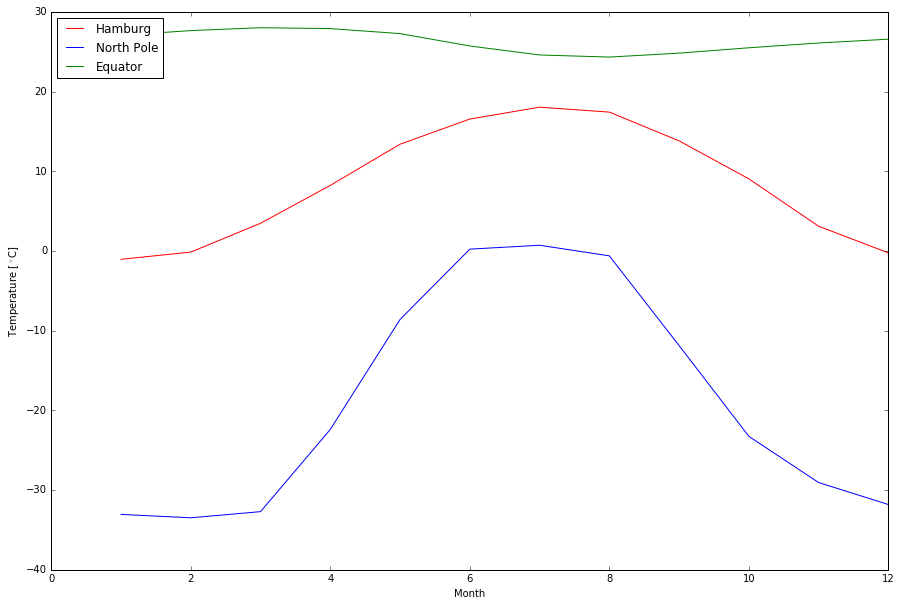

In [94]:
figure(figsize=(15,10))
N_locations=len(D.keys())
D_seasonal={}
for k in D.keys():
    y=D_timeseries[k]
    Seasonal=zeros(12)
    for m in range(12): # m is month index but month counts from 1 - 12 not 0 - 11
        Seasonal[m]=y[periods.month==m+1].mean()
    D_seasonal[k]=Seasonal
    plot(range(1,13),D_seasonal[k],color=col[k],label=k)
legend(loc=2)
xlabel('Month')
ylabel('Temperature [$^\circ$C]')
show()

# Calculate anomalies and trends

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


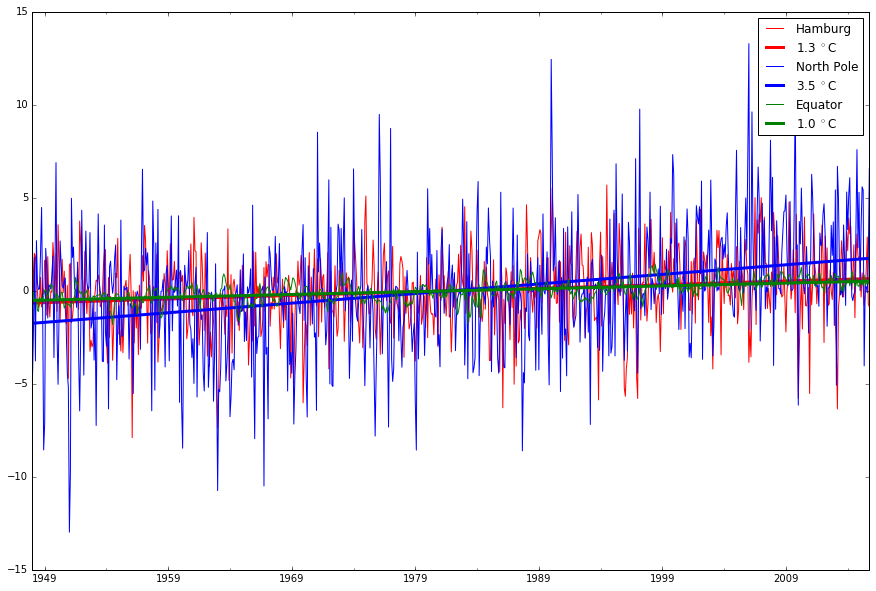

In [160]:
figure(figsize=(15,10))
N=len(periods)
Anomalies=zeros(N)
D_anom={}
for k in D.keys():
    for j,i in enumerate(dates):
        Anomalies[j]=D_timeseries[k][i]-D_seasonal[k][i.month-1]
    D_anom[k]=pd.Series(Anomalies,index=dates).copy()
    D_anom[k].plot(color=col[k],label=k)
# Add linear regression lines
    slope, intercept, r_value, p_value, std_err =stats.linregress(range(N),D_anom[k].values)
    fit=slope*range(N)+intercept
    S_fit=pd.Series(fit,index=dates)
    S_fit.plot(color=col[k],linewidth=3,label='%0.1f $^\circ$C  '%(slope*N))
legend()
